## interferometro

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("D:/Progetti/LabProgram")
import lab_utilities as lu
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import os

In [2]:
lu.setDefaultGraphStyle(size=(10,7))

## Interferometro di Fabry-Perot

In [3]:
distanza_lineablocco_muro = 188.25 # cm
err_distanza_lineablocco_muro = 0.05 # cm
distanza_linea_lente = 1.0 # cm
err_distanza_linea_lente = 0.05 # cm
distanza_specchi_fp = 0.5 #mm
distanza_fp_lente = 16.45 # cm
err_distanza_fp_lente = 0.5 # cm

distanza_lente_muro = distanza_lineablocco_muro + distanza_linea_lente
err_distanza_lente_muro = np.sqrt(err_distanza_lineablocco_muro**2 + err_distanza_linea_lente**2)
distanza_fp_muro = distanza_lente_muro - distanza_fp_lente
err_distanza_fp_muro = np.sqrt(err_distanza_lente_muro**2 + err_distanza_fp_lente**2)

In [19]:
print(distanza_fp_muro, err_distanza_fp_muro)

172.8 0.5049752469181039


In [4]:
#load data cerchi
data_cerchi = pd.read_csv("data/fabry-perot/cerchi.csv")
diameters = data_cerchi["right_line[cm]"] - data_cerchi["left_line[cm]"]
err_diameters = np.sqrt(data_cerchi["right_line_err[cm]"]**2 + data_cerchi["left_line_err[cm]"]**2)
radii = [d/2 for d in diameters]
err_radii = [d/2 for d in err_diameters]

#calculate thetas
thetas = [np.arctan(r/distanza_fp_muro) for r in radii]
#error : sqrt[(dist_m_fp/(radius^2 + dist_m_fp^2) * err_dist_muro_fp)^2 + (-radius/(radius^2 + dist_m_fp^2) * err_radius)^2]
err_thetas = [np.sqrt((distanza_fp_muro/(r**2 + distanza_fp_muro**2) * err_radii[i])**2 + (-r/(r**2 + distanza_fp_muro**2) * err_distanza_fp_muro)**2) for i,r in enumerate(radii)]

#calculate cos(thetas)
cos_thetas = [np.cos(t) for t in thetas]
err_cos_thetas = [np.sin(t) * err_thetas[i] for i,t in enumerate(thetas)]


In [17]:
#make latex table with cos(\theta), err_thetas and N
#N is a decreasing number from len(radii) to 1

df_cos = pd.DataFrame({"cos(theta)":cos_thetas, "err_cos(theta)":err_cos_thetas, "N":list(range(len(radii),0,-1))})

#export to csv
df_cos.to_csv("data/fabry-perot/cos_fit.csv", index=False)

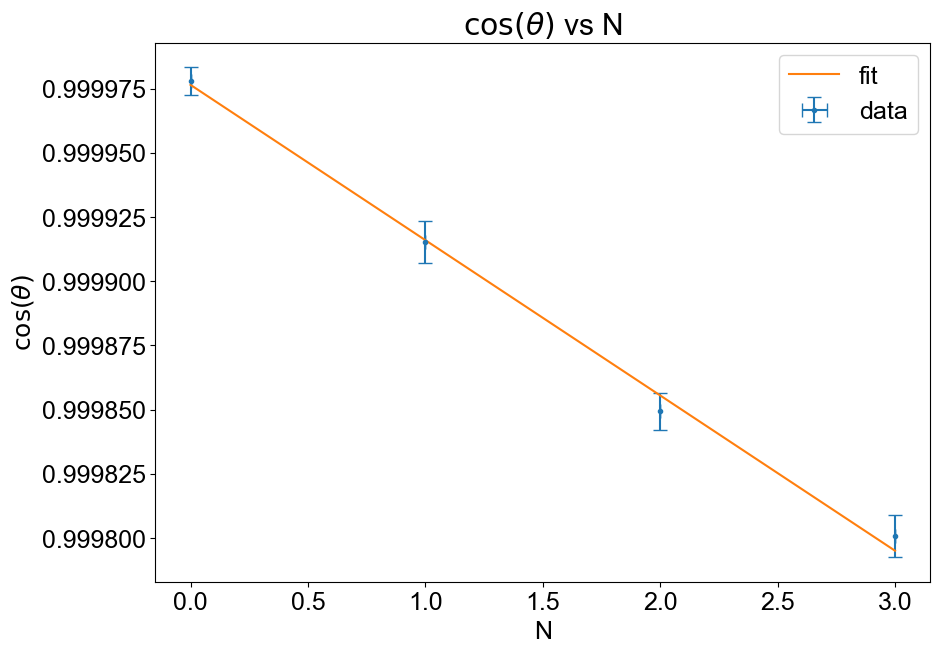

In [15]:
Ns = data_cerchi["index"]
#fit cos(theta) = a + b*N
def fit_func(N, a, b):
    return a + b*N

popt, pcov = curve_fit(fit_func, Ns, cos_thetas, sigma=err_cos_thetas)

#plot cos(theta) vs Ns
plt.errorbar(Ns, cos_thetas, xerr=0, yerr=err_cos_thetas, fmt='.', label="data")

#plot fit
x = np.linspace(0, 3, 1000)
plt.plot(x, fit_func(x, *popt), label="fit")

plt.xlabel("N")
plt.ylabel(r"$\cos(\theta)$")
plt.title(r"$\cos(\theta)$ vs N")
plt.legend()
plt.show()

In [18]:
#pritn fit params
print("a = {} +- {}".format(popt[0], np.sqrt(pcov[0,0])))
print("b = {} +- {}".format(popt[1], np.sqrt(pcov[1,1])))


a = 0.999976438361089 +- 4.013946305707829e-06
b = -6.046927118572876e-05 +- 2.440081245754037e-06


### Spostando lo specchio mobile

Si noti che bisogna calibrare la rotellina per gli spostamenti in un intervallo fissato in quanto potrebbe non essere calibrata ed inoltre la relazione potrebbe anche non essere lineare.

Prendiamo un intervallo di 20nm partendo da 200nm fino a 220nm.

In [22]:
lambda_ = 632.8 #nm
Delta_d_strumento = 20 #um

In [23]:
data_cerchi_mobili = pd.read_csv("data/fabry-perot/vario_dist_specchio.csv")

lambda_meter = lambda_ * 1e-9
#calculate delta_d for each delta_N: delta_d = delta_N * lambda / (2* cos(theta)) [approximate cos(theta) = 1]
delta_ds = [delta_N * lambda_meter / 2 for delta_N in data_cerchi_mobili["delta_N"]]
delta_d_mean = np.mean(delta_ds)
err_delta_d_mean = lu.st_dev(np.array(delta_ds))
#convert delta_d from m to mu_m
delta_d_mean *= 1e6
err_delta_d_mean *= 1e6
print("Delta_d = {:.2f} +- {:.2f} mu_m".format(delta_d_mean, err_delta_d_mean))

#calculate percentual error of incorrectness of instrument
err_incorrectness = delta_d_mean / Delta_d_strumento
print("Percentual error of instrument: {:.2f}%".format(err_incorrectness*100))

Delta_d = 16.61 +- 0.38 mu_m
Percentual error of instrument: 83.06%


## Interferometro di Michelson e Morley

### Misura di $\Delta_d$

Si ripete la misura per $\Delta_d$ fatta in precedenza ma con questa configurazione

In [27]:
dati_delta_d = pd.read_csv("data/michelson/delta_d.csv")
lambda_meter = lambda_ * 1e-9

delta_ds= [delta_N * lambda_meter / 2 for delta_N in dati_delta_d["delta_N"]]
delta_d_mean = np.mean(delta_ds)
err_delta_d_mean = lu.st_dev(np.array(delta_ds))
#convert delta_d from m to mu_m
delta_d_mean *= 1e6
err_delta_d_mean *= 1e6
print("Delta_d = {:.2f} +- {:.2f} mu_m".format(delta_d_mean, err_delta_d_mean))

#calculate percentual error of incorrectness of instrument
err_incorrectness = delta_d_mean / Delta_d_strumento
print("Percentual error of instrument: {:.2f}%".format(err_incorrectness*100))

Delta_d = 17.76 +- 0.60 mu_m
Percentual error of instrument: 88.79%


## Misura indice di rifrazione aria

In [1]:
def calculate_m(P_i, P_f, delta_N, d, lambda_):
    return (delta_N * lambda_ * d) / (2 * d * (P_f - P_i))

In [29]:
d = 0.5 #mm #lenght of chamber
gauge_error = 0.25  #error of pressure gauge

data_air = pd.read_csv("data/michelson/pressione_aria.csv")
data_air.head(10)

,P_i,P_f,delta_N
0,0,3,2
1,0,4,3
2,0,6,5
3,0,8,6
4,0,10,7
5,0,13,9
6,0,15,11
7,0,17,12
8,0,20,14


plot $\Delta P$ vs $\Delta N$ to check that the relation is linear

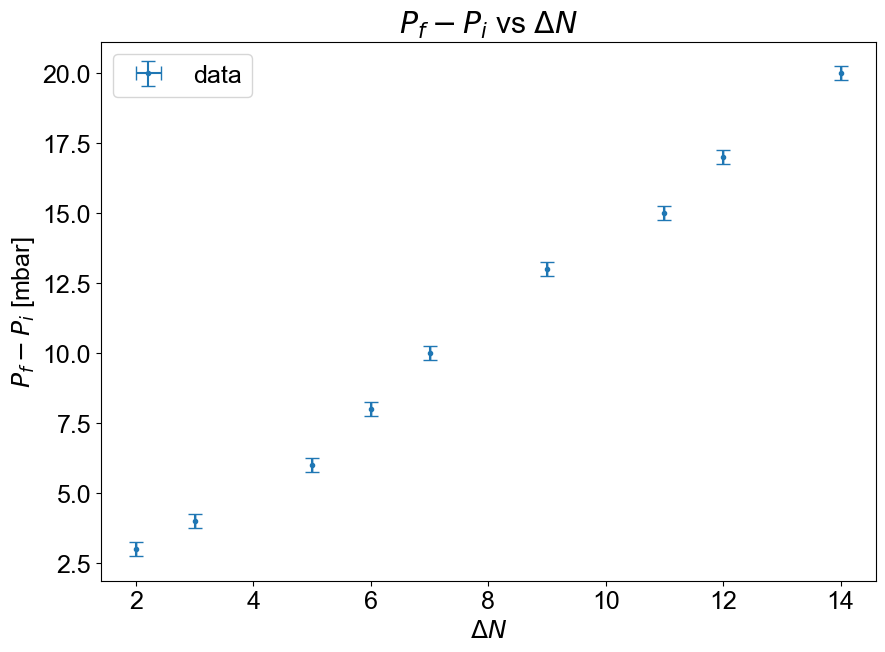

In [33]:
#plot P_f - P_i vs delta_N
Pf_Pi = data_air["P_f"] - data_air["P_i"]
plt.errorbar(data_air["delta_N"], Pf_Pi, xerr=0, yerr=gauge_error, fmt='.', label="data")

plt.xlabel(r"$\Delta N$")
plt.ylabel(r"$P_f - P_i$ [mbar]")
plt.title(r"$P_f - P_i$ vs $\Delta N$")
plt.legend()

In [34]:
#export Delta_P vs delta_N data
air_fit_data = pd.DataFrame({"delta_N": data_air["delta_N"], "Delta_P": Pf_Pi, "err_Delta_P": gauge_error})
air_fit_data.to_csv("data/michelson/air_fit_data.csv", index=False)

In [11]:
A = 0
B = 0
err_A = 0
err_B = 0
cov_AB = 0

m = B/(2*d)

[205.66, 210.93333333333334, 253.11999999999998, 221.47999999999996, 253.11999999999998, 210.93333333333334, 230.1090909090909]


## Misura indice di rifrazione vetro

In [40]:
d_v = 0.5 #mm #lenght of chamber
angle_error = 0.5 

data_v = pd.read_csv("data/michelson/vetro.csv")
data_v.head(10)

,angle_i,angle_f,delta_N
0,-2,1,15
1,-2,0,10
2,-2,2,20
3,-2,4,39
4,-2,6,53
5,-2,9,128


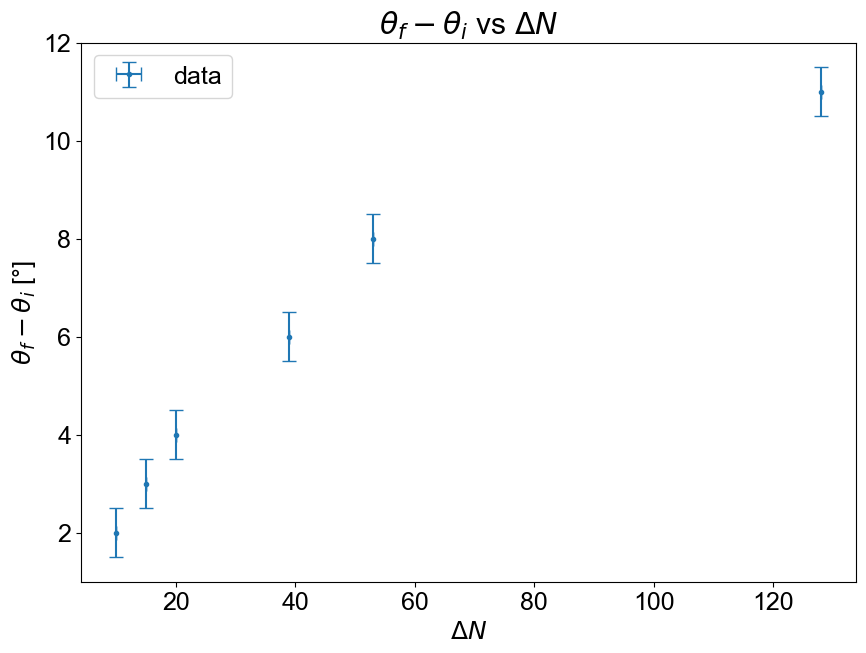

In [41]:
#plot P_f - P_i vs delta_N
delta_theta = data_v["angle_f"] - data_v["angle_i"]

plt.errorbar(data_v["delta_N"], delta_theta, xerr=0, yerr=angle_error, fmt='.', label="data")

plt.xlabel(r"$\Delta N$")
plt.ylabel(r"$\theta_f - \theta_i$ [°]")
plt.title(r"$\theta_f - \theta_i$ vs $\Delta N$")
plt.legend()

In [42]:
##info per delta cammino ottico
spessore_vetro = 6.325 #mm
err_spessore_vetro = 0.005 #mm

In [62]:
import math

# Function to calculate the initial formula
def calc_nv(d, deltaN, lambda_, phi):
    n_v = ((2*d - deltaN*lambda_)*(1 - math.cos(phi)))/(2*d*(1 - math.cos(phi)) - deltaN*lambda_)
    return n_v

# Function to calculate the square root of the error
def calc_error_nv(d, deltaN, lambda_, phi, sigma_d, sigma_phi, sigma_deltaN):
    df_d = (2*(1 - math.cos(phi)))/(-deltaN*lambda_ + 2*d*(1 - math.cos(phi))) - (2*(2*d - deltaN*lambda_)*(1 - math.cos(phi))**2)/(-deltaN*lambda_ + 2*d*(1 - math.cos(phi)))**2
    df_phi = ((2*d - deltaN*lambda_)*math.sin(phi))/(-deltaN*lambda_ + 2*d*(1 - math.cos(phi))) - (2*d*(2*d - deltaN*lambda_)*(1 - math.cos(phi))*math.sin(phi))/(-deltaN*lambda_ + 2*d*(1 - math.cos(phi)))**2
    df_deltaN = (lambda_*(2*d - deltaN*lambda_)*(1 - math.cos(phi)))/(-deltaN*lambda_ + 2*d*(1 - math.cos(phi)))**2 - (lambda_*(1 - math.cos(phi)))/(-deltaN*lambda_ + 2*d*(1 - math.cos(phi)))
    return math.sqrt((df_d*sigma_d)**2 + (df_phi*sigma_phi)**2 + (df_deltaN*sigma_deltaN)**2)


In [75]:
# Lists to store the results
n_v = []
error_nv = []
sigma_phi = math.radians(0.1)
sigma_deltaN = 0.5


# Calculate n_v and error_nv for each row in the data
for index, row in data_v.iterrows():
    angle_i = math.radians(row['angle_i'])
    angle_f = math.radians(row['angle_f'])
    delta_N = row['delta_N']
    phi = angle_f - angle_i
    n_v.append(calc_nv(spessore_vetro *1e-3, delta_N, lambda_ *1e-9, phi))
    error_nv.append(calc_error_nv(spessore_vetro *1e-3, delta_N, lambda_ *1e-9, phi, err_spessore_vetro *1e-3, sigma_phi, sigma_deltaN))

n_v = n_v[2:]
error_nv = error_nv[2:]
print(n_v)
print(error_nv)

#calculate weighted mean of n_v
n_v_mean = np.average(n_v, weights=[1/(err**2) for err in error_nv])
#propagation of error of weighted mean
sum_of_weights = sum([1/(err**2) for err in error_nv])
error_terms = [(1/(err*sum_of_weights))**2 for err in error_nv]
error_squared = sum(error_terms)
err_n_v_mean = math.sqrt(error_squared)
print("n_v = {:.3f} +- {:.3f}".format(n_v_mean, err_n_v_mean))

[1.695265959282307, 1.5500818440433917, 1.3707916704441803, 1.5251051615793612]
[0.0660161812324888, 0.030589048493244137, 0.013689361962968927, 0.01513255008076252]
n_v = 1.456 +- 0.010


## Interferenza Righello

In [123]:
d_due_punti = 1.7 *1e-2 #m
err_d_due_punti = np.sqrt((0.2*1e-2)**2 + (0.2*1e-2)**2)
dist_righello_muro = 1.18 #m
err_dist_righello_muro = 0.0005 #m
#spessore punto laser 0.4mm

#N_successivi
d_N1 = 4.7 * 1e-2
d_N2 = 6.3 * 1e-2
d_N3 = 7.6 * 1e-2
d_N4 = 8.5 * 1e-2

#calculate theta_inc
theta_inc = math.atan((d_due_punti)/(dist_righello_muro))
err_theta_inc = math.sqrt((err_d_due_punti * dist_righello_muro/(dist_righello_muro**2 + d_due_punti**2))**2 + (d_due_punti*err_dist_righello_muro/(dist_righello_muro**2 + d_due_punti**2))**2)

cos_theta_inc = math.cos(theta_inc)
err_cos_theta_inc = math.sin(theta_inc) * err_theta_inc

print("theta_inc = {:.3f} +- {:.3f}".format(math.degrees(theta_inc), math.degrees(err_theta_inc)))
print("cos_theta_inc = {:.6f} +- {:.6f}".format(cos_theta_inc, err_cos_theta_inc))

theta_inc = 0.825 +- 0.137
cos_theta_inc = 0.999896 +- 0.000035


[0.9992077078831979, 0.9985778027301954, 0.9979323140803109, 0.9974156119741332]


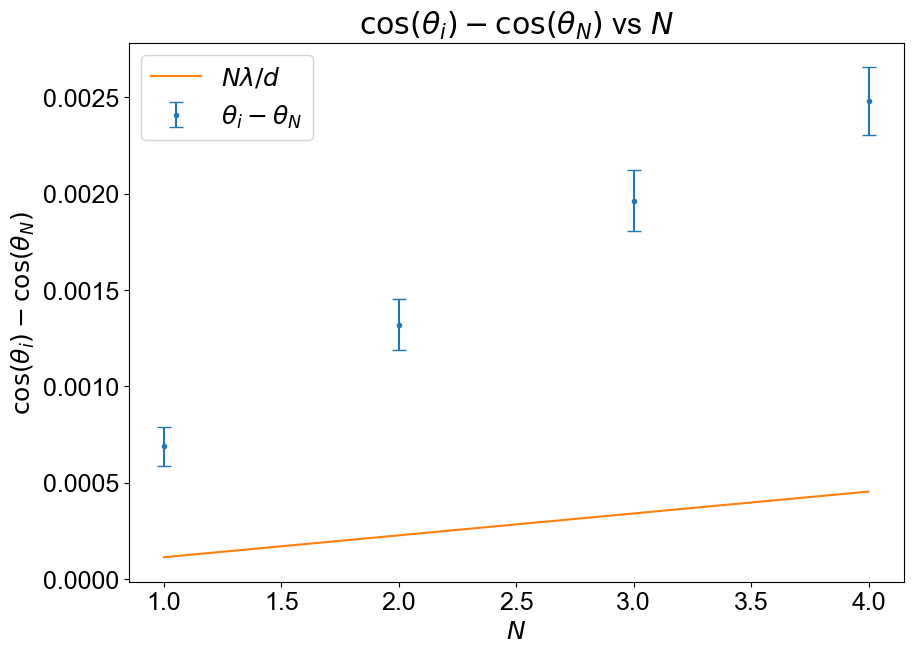

In [127]:
#calculate theta_N
theta_Ns = [math.atan((d_N)/(dist_righello_muro)) for d_N in [d_N1, d_N2, d_N3, d_N4]]
err_theta_Ns = [math.sqrt((err_d_due_punti * dist_righello_muro/(dist_righello_muro**2 + d_N**2))**2 + (d_N*err_dist_righello_muro/(dist_righello_muro**2 + d_N**2))**2) for d_N in [d_N1, d_N2, d_N3, d_N4]]


cos_theta_Ns = [math.cos(theta_N) for theta_N in theta_Ns]
err_cos_theta_Ns = [math.sin(theta_N) * err_theta_N for theta_N, err_theta_N in zip(theta_Ns, err_theta_Ns)]
print(cos_theta_Ns)

Ns = [1, 2, 3, 4]

#calculate delta_theta = theta_inc - theta_N
delta_thetas_cos = [cos_theta_inc - cos_theta_N for cos_theta_N in cos_theta_Ns]
err_delta_thetas = [math.sqrt(err_cos_theta_inc**2 + err_cos_theta_N**2) for err_cos_theta_N in err_cos_theta_Ns]

#plot delta_thetas_cos vs N
plt.figure()
plt.errorbar(Ns, delta_thetas_cos, yerr=err_delta_thetas, fmt='.', label=r"$\theta_i - \theta_N$")

#add line N*lambda/d
plt.plot(Ns, [N*(718)*1e-9/(spessore_vetro*1e-3) for N in Ns], label=r"$N\lambda/d$")

plt.xlabel(r"$N$")
plt.ylabel(r"$\cos(\theta_i) - \cos(\theta_N)$")
plt.title(r"$\cos(\theta_i) - \cos(\theta_N)$ vs $N$")
plt.legend()

In [91]:
#save delta cos theta  and N to csv
data = {'N': Ns, 'delta_cos_theta': delta_thetas_cos, 'err_delta_cos_theta': err_delta_thetas}
df = pd.DataFrame(data=data)
df.to_csv("data/righello/delta_cos_theta.csv", index=False)

In [101]:
#calculate lambda
b = 6.088*1e-4
err_b = 0.61*1e-4
lambda_calculated = b * dist_righello_muro
err_lambda_calculated = math.sqrt((err_b * dist_righello_muro)**2 + (b * err_dist_righello_muro)**2)

print("lambda = {:.6f} +- {:.6f}".format(lambda_calculated*1e9, err_lambda_calculated*1e9))

lambda = 718384.000000 +- 71980.643644


### Confronti per conclusioni

In [130]:
#$d_{fp} = (16.6 \pm 0.4) \, \mu m$.
#$d_{m} = (17.8 \pm 0.6) \, \mu m$
from scipy.stats import norm


t = (16.6 + 17.8)/np.sqrt((0.4)**2 + (0.6)**2)
# calculate the p-value
p_value = 1 - norm.cdf(t)

print("t-score:", t)
print("p-value:", p_value)

t-score: 47.70421687536971
p-value: 0.0
